This notebook contains the code that takes an unknotting number one knot and produces its Piccirillo friend. In the second part of the notebook, we apply this code to the low crossing knots and census knots and verifiy that the Piccirillo friend is always different from K whenever K is not a twisted Whitehead double.

In [7]:
import snappy
import time

#### Snappy tools #####

def all_positive(manifold):
    '''
    Checks if the solution type of a triangulation is positive.
    '''
    return manifold.solution_type() == 'all tetrahedra positively oriented'

def find_positive_triangulations(manifold,number=1,tries=100):
    '''
    Searches for one triangulation with a positive solution type.
    (Or if number is set to a different value also for different such triangulations.)
    '''
    M = manifold.copy()
    pos_triangulations=[]
    for i in range(tries):
        if all_positive(M):
            pos_triangulations.append(M)
            if len(pos_triangulations)==number:
                return pos_triangulations
            break
        M.randomize()
    for d in M.dual_curves(max_segments=500):
        X = M.drill(d)
        X = X.filled_triangulation()
        X.dehn_fill((1,0),-1)
        for i in range(tries):
            if all_positive(X):
                pos_triangulations.append(X)
                if len(pos_triangulations)==number:
                    return pos_triangulations
                break
            X.randomize()

    # In the closed case, here is another trick.
    if all(not c for c in M.cusp_info('is_complete')):
        for i in range(tries):
            # Drills out a random edge
            X = M.__class__(M.filled_triangulation())
            if all_positive(X):
                pos_triangulations.append(X)
                if len(pos_triangulations)==number:
                    return pos_triangulations
            break
            M.randomize()
    return pos_triangulations

def better_is_isometric_to(X,Y,index=100,try_hard=False):
    """
    Returns True if X and Y are isometric.
    Returns False if X and Y appear to be different.
     """ 
    for i in (0,index):
        w=False
        try:
            w=X.is_isometric_to(Y)
            if w==True:
                return w
        except (RuntimeError,snappy.SnapPeaFatalError):
            pass
        X.randomize()
        Y.randomize()
    if try_hard:
        pos_triang_X=find_positive_triangulations(X,number=1,tries=index)
        pos_triang_Y=find_positive_triangulations(Y,number=1,tries=index)
        for X in pos_triang_X:
            for Y in pos_triang_Y:
                w=better_is_isometric_to(X,Y,index=100,try_hard=False)
                if w==True:
                    return w
    return w

def is_unknot(PD,index=10):
    '''
    Returns True if it represents the unknot and False if the group looks not free abelian.
    '''
    K=snappy.Link(PD).exterior()
    if K.fundamental_group().num_generators()==1:
        return True
    for i in range(index):
        K.randomize()
        if K.fundamental_group().num_generators()==1:
            return True
    return False

def is_trivial_Jones(PD):
    '''
    Checks if the knot has trivial Jones.
    '''
    K=snappy.Link(PD)
    K.simplify()
    jones=K.jones_polynomial()
    if jones==1:
        return True
    return False

def change_crossing(PD_code,crossing):
    '''
    Changes the crossing.
    '''
    (a,b,c,d)=crossing
    PD_code.remove(crossing)
    PD_code.append((d,a,b,c))
    return PD_code

def find_unknotting_crossings(PD):
    '''
    Returns the unknotting crossings of a diagram.
    '''
    unknotting_crossings=[]
    for c in PD:
        PD_new=PD.copy()
        PD_new=change_crossing(PD_new,c)
        if is_unknot(PD_new,index=10):
            unknotting_crossings.append(c)
        else:
            try:
                if is_trivial_Jones(PD_new):
                    if is_unknot(PD_new,index=1000):
                        unknotting_crossings.append(c)
                    else:
                        print('We found a knot with trivial Jones polynomial that looks non trivial:',PD_new)
            except AssertionError:
                pass
    return unknotting_crossings

def sign_of_crossing(cros):
    '''
    Returns the sign of a crossing. (In a PD code that is ordered.)
    '''
    if cros[1]==0 and cros[3]!=1:
        return 1
    if cros[3]==0and cros[1]!=1:
        return -1
    if cros[1]>cros[3]:
        return +1
    return -1

def take_mirror(PD):
    '''Returns the mirror of the input diagram.'''
    PD_mirror=[]
    for c in PD:
        PD_mirror.append((c[1],c[2],c[3],c[0]))
    return PD_mirror

def number_of_strands(PD_code):
    '''
    Returns the number of strands in a diagram.
    '''
    X=[]
    for cros in PD_code:
        X=X+[x for x in cros]
    return max(X)+1 

def create_Piccirillo_RGB_link(PD,unknotting_cros):
    '''
    Takes a PD code and an unknotting crossing and creates a PD code of the Piccirillo RGB link.
    '''
    if sign_of_crossing(unknotting_cros)==-1:
        (PD,unknotting_cros)=(take_mirror(PD),(unknotting_cros[1],unknotting_cros[2],unknotting_cros[3],unknotting_cros[0]))
    m=number_of_strands(PD)
    (a,b,c,d)=unknotting_cros
    PD_new=PD.copy()
    PD_new.remove(unknotting_cros)
    PD_new.append((m+4,m+1,d,a))
    PD_new.append((m+4,m+5,m+3,m+8))  
    PD_new.append((m+5,b,m+6,m+3)) 
    PD_new.append((m+6,m+10,m+7,m+9)) 
    PD_new.append((m+9,m+7,m+12,m+8)) 
    PD_new.append((m+12,m+2,m+11,m+1)) 
    PD_new.append((m+2,m+10,c,m+11)) 
    return PD_new

def create_Piccirillo_duals(PD,try_hard=False):
    '''
    Takes as input a PD code of an unknotting number one diagram and returns triangulations of the Piccirillo duals.
    '''
    duals=[]
    K=snappy.Link(PD).exterior()
    cros=find_unknotting_crossings(PD)
    if cros==[]:
        return duals
    
    for c in cros:
        RGB=snappy.Link(create_Piccirillo_RGB_link(PD,c)).exterior()

        RGB.dehn_fill([(0,0),(0,1),(0,1)])
        B=RGB.filled_triangulation()
        if better_is_isometric_to(K,B,try_hard=try_hard)==True:
            RGB.dehn_fill([(-2,1),(0,0),(0,1)])
            G=RGB.filled_triangulation()
            if better_is_isometric_to(G,B,try_hard=try_hard)!=True:
                is_in_duals=False
                for Y in duals:
                    if better_is_isometric_to(Y,G)==True:
                        is_in_duals=True
                        break
                if is_in_duals==False:
                    duals.append(G)

            RGB.dehn_fill([(-2,1),(0,1),(0,0)])
            G=RGB.filled_triangulation()
            if better_is_isometric_to(G,B,try_hard=try_hard)!=True:
                is_in_duals=False
                for Y in duals:
                    if better_is_isometric_to(Y,G)==True:
                        is_in_duals=True
                        break
                if is_in_duals==False:
                    duals.append(G)

        RGB.dehn_fill([(0,1),(0,0),(0,1)])
        B=RGB.filled_triangulation()
        if better_is_isometric_to(K,B,try_hard=try_hard)==True:
            RGB.dehn_fill([(0,0),(-2,1),(0,1)])
            G=RGB.filled_triangulation()
            if better_is_isometric_to(G,B,try_hard=try_hard)!=True:
                is_in_duals=False
                for Y in duals:
                    if better_is_isometric_to(Y,G)==True:
                        is_in_duals=True
                        break
                if is_in_duals==False:
                    duals.append(G)

            RGB.dehn_fill([(0,1),(-2,1),(0,0)])
            G=RGB.filled_triangulation()
            if better_is_isometric_to(G,B,try_hard=try_hard)!=True:
                is_in_duals=False
                for Y in duals:
                    if better_is_isometric_to(Y,G)==True:
                        is_in_duals=True
                        break
                if is_in_duals==False:
                    duals.append(G)

        RGB.dehn_fill([(0,1),(0,1),(0,0)])
        B=RGB.filled_triangulation()
        if better_is_isometric_to(K,B,try_hard=False)==True:
            RGB.dehn_fill([(0,1),(0,0),(-2,1)])
            G=RGB.filled_triangulation()
            if better_is_isometric_to(G,B,try_hard=try_hard)!=True:
                is_in_duals=False
                for Y in duals:
                    if better_is_isometric_to(Y,G)==True:
                        is_in_duals=True
                        break
                if is_in_duals==False:
                    duals.append(G)

            RGB.dehn_fill([(0,0),(0,1),(-2,1)])
            G=RGB.filled_triangulation()
            if better_is_isometric_to(G,B,try_hard=try_hard)!=True:
                is_in_duals=False
                for Y in duals:
                    if better_is_isometric_to(Y,G)==True:
                        is_in_duals=True
                        break
                if is_in_duals==False:
                    duals.append(G)
                    
    return duals

def create_diagram(knot_complement,verbose=False):
    '''
    Takes a list of complements of a knot and creates a diagram.
    '''
    M=knot_complement
    M.dehn_fill((0,0))
    D=False
    try:
        M.set_peripheral_curves('shortest')
    except:
        pass
    try:
        D=M.exterior_to_link()
    except:
        pass
    if D==False:
        print('COULD NOT FIND A DIAGRAM!')
        print('------------') 
        return D
    else:
        D.simplify('global')
        PD_friend=D.PD_code()
        if verbose:
            print('Number of crossings of the friend:',len(PD_friend))
            #print(PD_friend)
        return PD_friend

### COMPUTING THE VOLUME

def better_volume(M,index=100,try_hard=False):
    '''Computes the verified volume. Returns 0 if SnapPy could not do it.'''
    count=0
    while count<index:
        try:
            return M.volume(verified=True)
        except:
            M.randomize()
            count=count+1
    if try_hard==True:
        pos_triang=find_positive_triangulations(M,number=1,tries=index)
        for X in pos_triang:
            vol=better_volume(X,index)
            if vol!=0:
                return vol
    return 0

Some examples:

In [2]:
for c in range(1,7):
    for K in snappy.HTLinkExteriors(knots_vs_links='knots',crossings=c):
        Pic_duals=create_Piccirillo_duals(K.link().PD_code(),try_hard=True)
        for X in Pic_duals:
            D=create_diagram(X)
            print(K.name(),D)
          

K6a1 [(32, 22, 33, 21), (33, 6, 34, 7), (14, 23, 15, 24), (12, 6, 13, 5), (9, 0, 10, 1), (2, 16, 3, 15), (3, 25, 4, 24), (28, 12, 29, 11), (25, 16, 26, 17), (10, 28, 11, 27), (36, 20, 37, 19), (37, 8, 0, 9), (22, 32, 23, 31), (4, 29, 5, 30), (7, 34, 8, 35), (20, 36, 21, 35), (13, 31, 14, 30), (18, 2, 19, 1), (17, 26, 18, 27)]
K6a2 [(37, 20, 38, 21), (12, 34, 13, 33), (10, 36, 11, 35), (3, 37, 4, 36), (26, 0, 27, 39), (2, 26, 3, 25), (19, 38, 20, 39), (7, 0, 8, 1), (18, 28, 19, 27), (9, 25, 10, 24), (31, 15, 32, 14), (30, 6, 31, 5), (28, 18, 29, 17), (16, 30, 17, 29), (15, 6, 16, 7), (22, 14, 23, 13), (1, 8, 2, 9), (21, 5, 22, 4), (23, 32, 24, 33), (34, 12, 35, 11)]


We check this on the low crossing and census knot data. 

First we load the list of knots which are known to have unknotting number 1.

In [2]:
u1lowcrossing = [
    "K3a1", "K4a1", "K5a1", "K6a3", "K6a2", "K6a1",
    "K7a4", "K7a2", "K7a1", "K8a11", "K8a6", "K8a16",
    "K8a9", "K8a7", "K8a1", "K8a14", "K8n1", "K8n2",
    "K9a27", "K9a22", "K9a17", "K9a3", "K9a21", "K9a2",
    "K9a7", "K9a15", "K9a12", "K9a5", "K9a1", "K9a11",
    "K9a28", "K9a32", "K9n4", "K9n1", "K9n2",
    "K10a75", "K10a65", "K10a110", "K10a64", "K10a107",
    "K10a63", "K10a57", "K10a111", "K10a58", "K10a34",
    "K10a69", "K10a55", "K10a109", "K10a31", "K10a32",
    "K10a2", "K10a1", "K10a10", "K10a3", "K10a83", "K10a50",
    "K10a11", "K10a106", "K10a47", "K10a97", "K10a118",
    "K10a66", "K10a36", "K10a77", "K10a88", "K10a85",
    "K10n18", "K10n19", "K10n13", "K10n4", "K10n3", "K10n2",
    "K10n25", "K10n26", "K10n23", "K10n24", "K10n32",
    "K10n34", "K10n38",
    "K11a8", "K11a10", "K11a11", "K11a12", "K11a34", "K11a35",
    "K11a41", "K11a56", "K11a69", "K11a70", "K11a71", "K11a73",
    "K11a77", "K11a78", "K11a80", "K11a82", "K11a86", "K11a88",
    "K11a91", "K11a96", "K11a98", "K11a101", "K11a104", "K11a106",
    "K11a114", "K11a121", "K11a122", "K11a136", "K11a138", "K11a139",
    "K11a146", "K11a149", "K11a160", "K11a167", "K11a168", "K11a180",
    "K11a184", "K11a187", "K11a189", "K11a190", "K11a195", "K11a198",
    "K11a209", "K11a210", "K11a216", "K11a222", "K11a226", "K11a230",
    "K11a233", "K11a247", "K11a255", "K11a256", "K11a257", "K11a264",
    "K11a266", "K11a267", "K11a272", "K11a280", "K11a282", "K11a283",
    "K11a287", "K11a289", "K11a290", "K11a300", "K11a307", "K11a311",
    "K11a326", "K11a345", "K11a351", "K11n1", "K11n12", "K11n18",
    "K11n20", "K11n21", "K11n22", "K11n25", "K11n26", "K11n28",
    "K11n34", "K11n38", "K11n39", "K11n42", "K11n45", "K11n48",
    "K11n50", "K11n52", "K11n53", "K11n55", "K11n56", "K11n62",
    "K11n63", "K11n82", "K11n84", "K11n85", "K11n86", "K11n87",
    "K11n96", "K11n100", "K11n101", "K11n110", "K11n111", "K11n114",
    "K11n123", "K11n124", "K11n125", "K11n130", "K11n131", "K11n134",
    "K11n143", "K11n145", "K11n151", "K11n152", "K11n153", "K11n154",
    "K11n156", "K11n159", "K11n176", "K11n184",
    "K12a1", "K12a2", "K12a6", "K12a8", "K12a19", "K12a20", "K12a22",
    "K12a25", "K12a27", "K12a28", "K12a31", "K12a40", "K12a58",
    "K12a61", "K12a73", "K12a80", "K12a121", "K12a138", "K12a151",
    "K12a173", "K12a174", "K12a180", "K12a184", "K12a191", "K12a202",
    "K12a208", "K12a209", "K12a214", "K12a217", "K12a220", "K12a256",
    "K12a261", "K12a272", "K12a280", "K12a282", "K12a287", "K12a290",
    "K12a300", "K12a301", "K12a303", "K12a308", "K12a309", "K12a310",
    "K12a316", "K12a340", "K12a346", "K12a358", "K12a359", "K12a360",
    "K12a374", "K12a388", "K12a407", "K12a415", "K12a426", "K12a439",
    "K12a451", "K12a455", "K12a467", "K12a470", "K12a483", "K12a497",
    "K12a498", "K12a509", "K12a524", "K12a535", "K12a537", "K12a551",
    "K12a559", "K12a560", "K12a571", "K12a579", "K12a585", "K12a588",
    "K12a604", "K12a606", "K12a608", "K12a614", "K12a626", "K12a631",
    "K12a635", "K12a637", "K12a646", "K12a656", "K12a662", "K12a670",
    "K12a695", "K12a696", "K12a697", "K12a715", "K12a721", "K12a729",
    "K12a732", "K12a736", "K12a744", "K12a745", "K12a751", "K12a761",
    "K12a765", "K12a766", "K12a770", "K12a773", "K12a774", "K12a781",
    "K12a793", "K12a799", "K12a803", "K12a807", "K12a821", "K12a849",
    "K12a851", "K12a857", "K12a858", "K12a864", "K12a865", "K12a875",
    "K12a887", "K12a888", "K12a893", "K12a919", "K12a928", "K12a935",
    "K12a944", "K12a954", "K12a966", "K12a976", "K12a993", "K12a998",
    "K12a1005", "K12a1008", "K12a1011", "K12a1023", "K12a1034", "K12a1048",
    "K12a1056", "K12a1060", "K12a1063", "K12a1076", "K12a1081", "K12a1126",
    "K12a1128", "K12a1129", "K12a1130", "K12a1135", "K12a1139", "K12a1140",
    "K12a1169", "K12a1176", "K12a1182", "K12a1187", "K12a1188", "K12a1198",
    "K12a1199", "K12a1217", "K12a1219", "K12a1228", "K12a1231", "K12a1235",
    "K12a1239", "K12a1245", "K12a1249", "K12a1250", "K12a1258", "K12a1268",
    "K12a1271", "K12a1273", "K12n1", "K12n4", "K12n5", "K12n7", "K12n13",
    "K12n20", "K12n23", "K12n24", "K12n25", "K12n28", "K12n31", "K12n34",
    "K12n35", "K12n36", "K12n38", "K12n39", "K12n46", "K12n65", "K12n69",
    "K12n70", "K12n79", "K12n121", "K12n124", "K12n129", "K12n142",
    "K12n146", "K12n152", "K12n165", "K12n198", "K12n218", "K12n231",
    "K12n232", "K12n249", "K12n250", "K12n252", "K12n255", "K12n262",
    "K12n263", "K12n271", "K12n272", "K12n275", "K12n277", "K12n279",
    "K12n300", "K12n306", "K12n310", "K12n311", "K12n313", "K12n320",
    "K12n322", "K12n325", "K12n340", "K12n342", "K12n343", "K12n347",
    "K12n350", "K12n352", "K12n358", "K12n360", "K12n362", "K12n369",
    "K12n370", "K12n371", "K12n372", "K12n381", "K12n392", "K12n400",
    "K12n412", "K12n424", "K12n429", "K12n430", "K12n434", "K12n435",
    "K12n446", "K12n447", "K12n450", "K12n461", "K12n464", "K12n467",
    "K12n468", "K12n482", "K12n483", "K12n484", "K12n485", "K12n487",
    "K12n488", "K12n492", "K12n493", "K12n499", "K12n504", "K12n511",
    "K12n534", "K12n535", "K12n536", "K12n547", "K12n552", "K12n560",
    "K12n566", "K12n572", "K12n573", "K12n579", "K12n584", "K12n588",
    "K12n599", "K12n610", "K12n613", "K12n614", "K12n616", "K12n620",
    "K12n628", "K12n633", "K12n645", "K12n646", "K12n650", "K12n656",
    "K12n667", "K12n687", "K12n704", "K12n705", "K12n709", "K12n710",
    "K12n715", "K12n718", "K12n719", "K12n727", "K12n732", "K12n736",
    "K12n740", "K12n748", "K12n754", "K12n767", "K12n771", "K12n785",
    "K12n786", "K12n787", "K12n789", "K12n816", "K12n828", "K12n831",
    "K12n852", "K12n858", "K12n871", "K12n884"]

u1census= ["m004","m015","m032","m053","m074","m094","m199","m201","m222","m224","m289",
    "o9_00017","o9_00022","o9_01024","o9_01035","o9_02030","o9_02163","o9_04037",
    "o9_04139","o9_04950","o9_05028","o9_12414","o9_18772","o9_18931","o9_19031",
    "o9_20180","o9_22951","o9_23147","o9_27215","o9_27542","o9_31828","o9_34743",
    "o9_36320","o9_37080","o9_37731","o9_37732","o9_39277","o9_40024","o9_40081",
    "o9_40484","o9_40485","o9_40568","o9_42258","o9_42320","o9_42660","o9_43592",
    "o9_43771","s016","s023","s188","s194","s239","s912", "t00017","t00027","t00565",
    "t00577","t01039","t01142","t01901","t02019","t02069","t02188","t07281","t07452",
    "t09927","t11034","t11291","t11402","t12270","t12271","t12344","t12587","t12656",
    "v0016","v0025","v0321","v0329","v0521","v0595","v1971","v2272","v2508","v3505"]

print('Low crossing knots with unknotting number 1:',len(u1lowcrossing))
print('Census knots with unknotting number 1:',len(u1census))

Low crossing knots with unknotting number 1: 505
Census knots with unknotting number 1: 84


Then we check if we find a Piccirillo friend of them.

In [3]:
start=time.time()

friends=[]
no_friend=[]

for name in u1lowcrossing:
    D=snappy.Link(name)
    F=create_Piccirillo_duals(D.PD_code())
    friends.append([name,F])
    
for name in u1census:
    K=snappy.Manifold(name)
    D=K.exterior_to_link()
    F=create_Piccirillo_duals(D.PD_code())
    if F!=[]:
        friends.append([name,F])
    if F==[]:
        no_friend.append(name)
    
print('Knots for which we found a friend:',len(friends))
print('Knots for which we could not find a friend:',len(no_friend))
print('Seconds taken:',time.time()-start)

Knots for which we found a friend: 574
Knots for which we could not find a friend: 15
Seconds taken: 530.5944590568542


In [4]:
start=time.time()

could_not_find_friend=[]

for name in no_friend:
    K=snappy.Manifold(name)
    D=K.exterior_to_link()
    F=create_Piccirillo_duals(D.PD_code())
    if F!=[]:
        friends.append([name,F])
    if F==[]:
        D.simplify('global')
        F=create_Piccirillo_duals(D.PD_code())
        if F!=[]:
            friends.append([name,F])
        if F==[]:
            could_not_find_friend.append(name)
    
print('Knots for which we found a friend:',len(friends))
print('Knots for which we could not find a friend:',len(could_not_find_friend))
print('Seconds taken:',time.time()-start)

Knots for which we found a friend: 575
Knots for which we could not find a friend: 14
Seconds taken: 30.85386085510254


Next, we verify that these friends are really diferent from the starting knots.

In [13]:
start=time.time()

verified_friends=[]
unclear_friends=[]

for [knot,fr] in friends:
    K=snappy.Manifold(knot)
    volK=better_volume(K)
    if volK!=0:
        for F in fr:
            volF=better_volume(F)
            if volF!=0:
                if volF.overlaps(volK)==False:
                    if knot not in [x[0] for x in verified_friends]:
                        verified_friends.append([knot,F])
                
unclear_friends=[x for x in friends if x[0] not in [y[0] for y in verified_friends]]

print('Verified friends:',len(verified_friends))
print('Unclear friends:',len(unclear_friends))
print('time taken:',time.time()-start, 'seconds')

Verified friends: 563
Unclear friends: 12
time taken: 115.69244408607483 seconds


For the remianing knots we print diagrams from which we read-off that they are twist knots.

In [22]:
for knot in [x[0] for x in unclear_friends]+could_not_find_friend:
    K=snappy.Manifold(knot)
    print(knot,K.identify())

K3a1 []
K4a1 [m004(0,0), 4_1(0,0), K2_1(0,0), K4a1(0,0), otet02_00001(0,0)]
K5a1 [m015(0,0), 5_2(0,0), K3_2(0,0), K5a1(0,0)]
K6a3 [m032(0,0), 6_1(0,0), K4_1(0,0), K6a3(0,0)]
K7a4 [m053(0,0), 7_2(0,0), K4_2(0,0), K7a4(0,0)]
K8a11 [m074(0,0), 8_1(0,0), K5_2(0,0), K8a11(0,0)]
K9a27 [m094(0,0), 9_2(0,0), K5_3(0,0), K9a27(0,0)]
K10a75 [s016(0,0), 10_1(0,0), K6_1(0,0), K10a75(0,0)]
K11a247 [s023(0,0), 11_552(0,0), K6_2(0,0), K11a247(0,0)]
K12a803 [v0016(0,0), K7_1(0,0), K12a803(0,0)]
o9_00017 [o9_00017(0,0), K9_1(0,0)]
v0025 [v0025(0,0), K7_2(0,0), K13a3143(0,0)]
m004 [m004(0,0), 4_1(0,0), K2_1(0,0), K4a1(0,0), otet02_00001(0,0)]
m015 [m015(0,0), 5_2(0,0), K3_2(0,0), K5a1(0,0)]
m032 [m032(0,0), 6_1(0,0), K4_1(0,0), K6a3(0,0)]
m053 [m053(0,0), 7_2(0,0), K4_2(0,0), K7a4(0,0)]
m074 [m074(0,0), 8_1(0,0), K5_2(0,0), K8a11(0,0)]
m094 [m094(0,0), 9_2(0,0), K5_3(0,0), K9a27(0,0)]
o9_00022 [o9_00022(0,0), K9_2(0,0)]
o9_22951 [o9_22951(0,0), K9_321(0,0)]
s016 [s016(0,0), 10_1(0,0), K6_1(0,0), K10a75(0

In [23]:
snappy.Link('K3a1').sage_link().plot()

In [24]:
snappy.Link('K4a1').sage_link().plot()

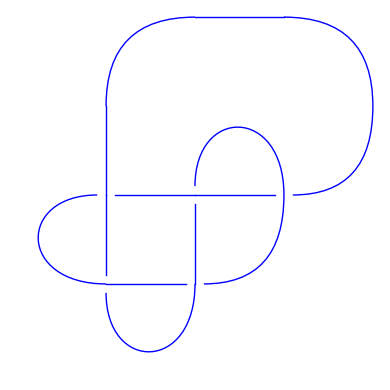

In [25]:
snappy.Link('K5a1').sage_link().plot()

In [26]:
snappy.Link('K6a3').sage_link().plot()

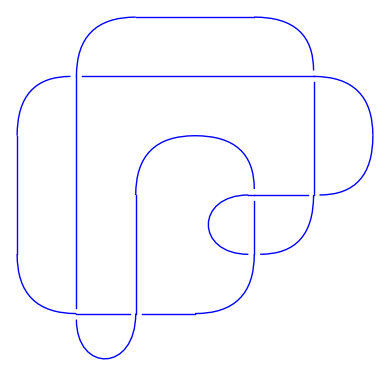

In [27]:
snappy.Link('K7a4').sage_link().plot()

In [28]:
snappy.Link('K8a11').sage_link().plot()

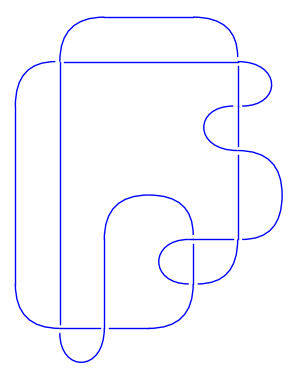

In [29]:
snappy.Link('K9a27').sage_link().plot()

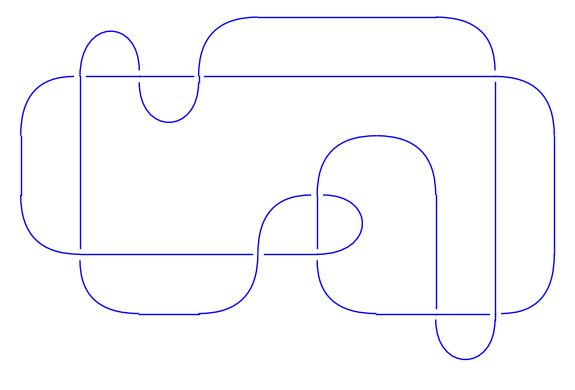

In [30]:
snappy.Link('K10a75').sage_link().plot()

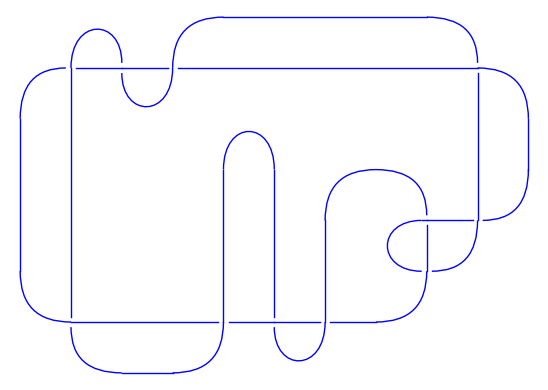

In [31]:
snappy.Link('K11a247').sage_link().plot()

In [32]:
snappy.Link('K12a803').sage_link().plot()

In [33]:
snappy.Link('K13a3143').sage_link().plot()

In [35]:
snappy.Link('K14a12741').sage_link().plot()

In [36]:
snappy.Link('K15a54894').sage_link().plot()

In [37]:
K=snappy.Manifold('K9_1')
D=K.exterior_to_link()
D.simplify('global')
D.sage_link().plot()

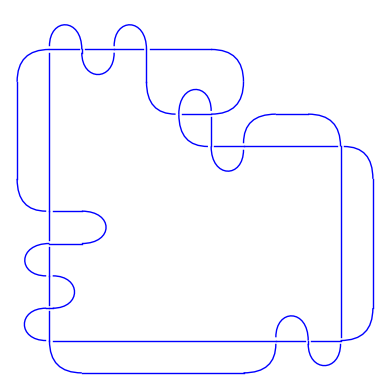

In [38]:
K=snappy.Manifold('K9_2')
D=K.exterior_to_link()
D.simplify('global')
D.sage_link().plot()

The following two are not twist knots.

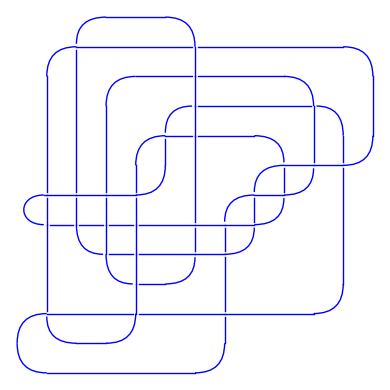

In [39]:
K=snappy.Manifold('K9_321')
D=K.exterior_to_link()
D.simplify('global')
D.sage_link().plot()

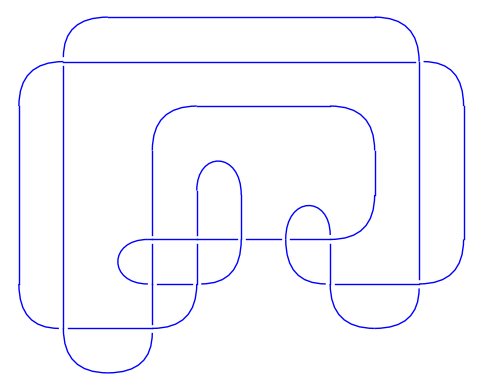

In [34]:
snappy.Link('K13n469').sage_link().plot()

K13n469 and K9_321 are actually friends with their mirror and they are both not isotopic to their mirrors as discussed in [Abe-Kegel-Weiss]. 